In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Section 1: Load the Data

In [3]:
#Data saved in csv/excel
import glob, os

data_dir= "C:/Users/tsb7592/Box/ARMADA ROC/data"
os.chdir(data_dir)

In [4]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
raw= pd.read_csv("ARMADA_TBSCORES_MAY2020.csv")
raw.shape

(1083, 189)

# Section 2: Data Cleaning

In [6]:
#Only keep the rows with assmnt = 1
df = raw[raw.assmnt==1]

In [7]:
df.shape

(817, 189)

In [8]:
#Only keeping the columns for cognition
df = df.iloc[:, :69 ]

In [9]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,PSM_FCTScore,PSM_Raw,PSM_SE,PSM_Theta,PSM_UCSScore,TPVT_ACSScore,TPVT_FCTScore,TPVT_SE,TPVT_Theta,TPVT_UCSScore
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,52.0,7.0,0.32,-1.152,93.0,93.0,39.0,0.495,4.061,102.0
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482,4.834,105.0
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,NaN,1.0,0.41,-1.990,79.0,NaN,NaN,0.493,6.309,112.0
5,1.46931,1,Emory,6,en-US,73,2,1,2,0,...,48.0,6.0,0.33,-1.216,92.0,97.0,49.0,0.465,4.953,106.0
6,1.47476,1,Emory,3,en-US,66,1,1,2,0,...,52.0,7.0,0.32,-1.150,93.0,116.0,58.0,0.490,7.292,117.0


In [10]:
#UWisc, Mass, NU, and UMich
df.site.value_counts()

CU       197
UMich    117
UWisc    114
Mass     106
UCSD      81
NU        75
Emory     66
UPitt     38
Mayo      23
Name: site, dtype: int64

In [11]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [12]:
#Rename the value under column cohort2
df['cohort2'] = df['cohort2'].map(cohort)

In [13]:
df.AGE.max()

99

In [14]:
df.cohort2.value_counts()

Gen population 65-85                          161
Gen population healthy aging 85+              115
Spanish Speaking normal controls 65-85        107
Gen population MCI                            104
Spanish Speaking mild cognitive impairment    104
African American normal controls 65-85         94
Gen population AD                              71
African American mild cognitive impairment     38
Spanish Speaking AD                            23
Name: cohort2, dtype: int64

In [15]:
cohort_groups =["Gen population 65-85", "Gen population MCI",
             "Gen population AD","Gen population healthy aging 85+",
               "Spanish Speaking mild cognitive impairment",
                                           "Spanish Speaking normal controls 65-85", "Spanish Speaking AD"]

In [16]:
#To select rows whose column value is in cohort_groups
#df =df[df.cohort2.isin(cohort_groups)]

In [17]:
edu={1:"None",
2 :"Less than HS",
3 :"Less than HS",
4 :"Less than HS",
5 :"Less than HS",
6 :"Less than HS",
7 :"Less than HS",
8 :"Less than HS",
9 :"Less than HS",
10 :"Less than HS",
11 :"Less than HS",
12 :"Less than HS",
13 :"Less than HS",
14 :"Less than HS",
16 :"High School",
18 :"Some College",
20 :"Some College",
21 :"College Degree",
22 :"Graduate Degree",
23 :"Graduate Degree",
24 :"Graduate Degree",
25 :"Some College",
26 :"Some College",
27 :"Some College",
28 :"None",
999:"Unknown"}

In [18]:
df['EDUCATION'] = df['EDUCATION'].map(edu)

In [19]:
df['SEX'] = df['gender_rc']-1

In [20]:
#Create new columns cohort_groups, cognitive_status
df.loc[df['cohort2'].str.contains('Gen population'), 'cohort_group'] = 'GenPop'
df.loc[df['cohort2'].str.contains('Spanish'), 'cohort_group'] = 'Spanish'
df.loc[df['cohort2'].str.contains('African American'), 'cohort_group'] = 'AA'

In [21]:
#Create new columns cognitive_status 
df.loc[df['cohort2'].str.contains('mild cognitive impairment|MCI'), 'cognitive_status'] = 'MCI'
df.loc[df['cohort2'].str.contains('AD'), 'cognitive_status'] = 'AD'
df.loc[df['cohort2'].str.contains('normal controls'), 'cognitive_status'] = 'NC'
df.loc[df['cohort2'].str.contains('65-85'), 'cognitive_status'] = '65-85'
df.loc[df['cohort2'].str.contains('healthy aging 85+'), 'cognitive_status'] = 'Healthy aging 85+'
df['cognitive_status'].head()

0    65-85
1       AD
3      MCI
5    65-85
6      MCI
Name: cognitive_status, dtype: object

#  MCI vs. Gen pop 65-85

In [22]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,PSM_Theta,PSM_UCSScore,TPVT_ACSScore,TPVT_FCTScore,TPVT_SE,TPVT_Theta,TPVT_UCSScore,SEX,cohort_group,cognitive_status
0,1.45635,1,Emory,African American normal controls 65-85,en-US,82,2,1,2,0,...,-1.152,93.0,93.0,39.0,0.495,4.061,102.0,1,AA,65-85
1,1.46421,1,Emory,Gen population AD,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,0.482,4.834,105.0,0,GenPop,AD
3,1.46422,1,Emory,Gen population MCI,en-US,88,2,1,1,1,...,-1.990,79.0,NaN,NaN,0.493,6.309,112.0,1,GenPop,MCI
5,1.46931,1,Emory,African American normal controls 65-85,en-US,73,2,1,2,0,...,-1.216,92.0,97.0,49.0,0.465,4.953,106.0,1,AA,65-85
6,1.47476,1,Emory,Gen population MCI,en-US,66,1,1,2,0,...,-1.150,93.0,116.0,58.0,0.490,7.292,117.0,0,GenPop,MCI


In [23]:
ac = [col for col in df.columns if 'ACS' in col]
ac

['CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore']

In [24]:
fc = [col for col in df.columns if 'FCT' in col]
fc

['CCC_FCTScore',
 'CFC_FCTScore',
 'CTC_FCTScore',
 'DCCS_FCTScore',
 'Flanker_FCTScore',
 'LSWM_FCTScore',
 'ORR_FCTScore',
 'PCPS_FCTScore',
 'PSM_FCTScore',
 'TPVT_FCTScore']

In [25]:
uc=[col for col in df.columns if 'UCS' in col]
uc

['CCC_UCSScore',
 'CFC_UCSScore',
 'CTC_UCSScore',
 'DCCS_UCSScore',
 'Flanker_UCSScore',
 'LSWM_UCSScore',
 'ORR_UCSScore',
 'PCPS_UCSScore',
 'PSM_UCSScore',
 'TPVT_UCSScore']

In [26]:
age_edu = ['cognitive_status','AGE','College Degree', 'Graduate Degree', 'High School', 'Less than HS',
        'None', 'Some College']

[ROC Curves, confusion matrix](https://scikit-plot.readthedocs.io/en/stable/metrics.html)

In [27]:
def dummy_variable(variable, df):
    '''
    Using the binned columns, replace them with dummy columns.
    Inputs:
    df: A panda dataframe
    variable: A list of column headings for binned variables
    Outputs:
    df:A panda dataframe
    '''
    dummy_df = pd.get_dummies(df[variable]).rename(columns = lambda x: str(x))
    df = pd.concat([df, dummy_df], axis=1)
    df.drop([variable], inplace = True, axis=1)
    
    return df

In [28]:
# CREATING DUMMIES for EDUCATION
SCOL = ['EDUCATION']
print ('The following columns have been broken into dummies:' , SCOL)
for dummy in SCOL:
    df = dummy_variable(dummy, df)
print (' ')

The following columns have been broken into dummies: ['EDUCATION']
 


In [29]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,TPVT_UCSScore,SEX,cohort_group,cognitive_status,College Degree,Graduate Degree,High School,Less than HS,None,Some College
0,1.45635,1,Emory,African American normal controls 65-85,en-US,82,2,1,2,0,...,102.0,1,AA,65-85,0,1,0,0,0,0
1,1.46421,1,Emory,Gen population AD,en-US,88,1,1,1,1,...,105.0,0,GenPop,AD,1,0,0,0,0,0
3,1.46422,1,Emory,Gen population MCI,en-US,88,2,1,1,1,...,112.0,1,GenPop,MCI,1,0,0,0,0,0
5,1.46931,1,Emory,African American normal controls 65-85,en-US,73,2,1,2,0,...,106.0,1,AA,65-85,1,0,0,0,0,0
6,1.47476,1,Emory,Gen population MCI,en-US,66,1,1,2,0,...,117.0,0,GenPop,MCI,0,1,0,0,0,0


In [54]:
def select_subset(df, col, Uncorrected= False):
    '''
    Select the subset of dataset based on congitive status, races and num of indedpendt variables.
    Inputs: 
        df: the dataframe

      
    Returns: X, y and the title for the figure
    '''
    l = [col, 'cognitive_status']
    if Uncorrected:
        l = age_edu.copy()
        l.append(col)
        sub = df[l]

    sub = df[l].dropna()

    # Binarize the output
    y = np.where(sub.cognitive_status =='MCI', 1, 0)
    t = 'MCI vs. 65-85'

    X = np.array(sub[col])
    X = np.reshape(X, (-1,1))
    return X, y ,t
   

In [31]:
def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = round(precision_score(y_true, preds_at_k), 2)
    recall = round(recall_score(y_true, preds_at_k), 2)
    f1 = round(f1_score(y_true, preds_at_k),2)
    return precision, recall, f1

[Finding thresholds](https://amirhessam88.github.io/finding-thresholds/)

In [32]:
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

In [33]:
from math import sqrt
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = round((AUC - 1.96*SE_AUC), 2)
    upper = round((AUC + 1.96*SE_AUC), 2)
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

In [64]:
from statsmodels.stats.power import TTestIndPower
def _threshold_finder(X, y_true,t):
    """
    a function to find the optimal threshold for binary classification
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)  


    return the dataframe contains the results of each regression
    """
    if np.all((y_true== 0)):
        print(t, 'does not have class 1')
        return 
    
    results_df = pd.DataFrame(columns=('Title', 'Accuracy','AUC-ROC', '95% CI','Min_Sample','AVG Precision','Youden index','Precision,Recall,F1 at_50'))
    
    model =  LogisticRegression(random_state=0).fit(X, y)
    probas = model.predict_proba(X)
    y_predict_proba  = model.predict_proba(X)[:,1]
    y_pred = model.predict(X)
    accuracy = round(model.score(X, y),2)

    CI = roc_auc_ci(y_true, y_predict_proba, positive=1)
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
  

    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)

    #Zip, unzip to ensure corresponding order
    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_predict_proba, y), reverse=True))
    
    # parameters for power analysis
    effect = roc_auc_score(y, y_predict_proba)
    alpha = 0.05
    power = 0.8
    # perform power analysis
    analysis = TTestIndPower()
    Min_Sample = round(analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha),2)

    
    results_df.loc[len(results_df)] = [t, accuracy, round(roc_auc_score(y, y_predict_proba),2),CI, Min_Sample,
                                    round(average_precision_score(y, y_predict_proba),2), round(youden_threshold,2),
                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]

    plt.figure(figsize = (5, 5))
    plt.plot(1)  # one row, two columns, fist cell
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.2f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "green", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "green", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)
    plt.title(t, fontsize = 12)



    plt.show()
     
    #skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True,title='Normalized Confusion Matrix '+t)

    return results_df
    

In [35]:
def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

In [56]:
set1

,Title,Accuracy,AUC-ROC,95% CI,AVG Precision,Youden index,"Precision,Recall,F1 at_50"
0,CCC_ACSScore,0.66,0.68,"(0.63, 0.72)",0.55,0.40,"(0.52, 0.68, 0.59)"
1,CFC_ACSScore,0.72,0.74,"(0.69, 0.79)",0.57,0.40,"(0.51, 0.75, 0.61)"
2,CTC_ACSScore,0.72,0.74,"(0.69, 0.79)",0.56,0.38,"(0.5, 0.75, 0.6)"
3,DCCS_ACSScore,0.66,0.66,"(0.62, 0.71)",0.51,0.43,"(0.49, 0.64, 0.56)"
4,Flanker_ACSScore,0.64,0.63,"(0.59, 0.68)",0.49,0.32,"(0.48, 0.64, 0.55)"
5,LSWM_ACSScore,0.74,0.74,"(0.7, 0.78)",0.66,0.48,"(0.53, 0.72, 0.61)"
6,ORR_ACSScore,0.66,0.68,"(0.63, 0.72)",0.55,0.41,"(0.54, 0.71, 0.61)"
7,PCPS_ACSScore,0.64,0.64,"(0.6, 0.69)",0.50,0.44,"(0.49, 0.64, 0.55)"
8,PSM_ACSScore,0.68,0.74,"(0.69, 0.79)",0.57,0.36,"(0.53, 0.75, 0.62)"
9,TPVT_ACSScore,0.64,0.66,"(0.62, 0.71)",0.54,0.38,"(0.52, 0.67, 0.59)"


In [36]:
import scikitplot as skplt

In [37]:
fc

['CCC_FCTScore',
 'CFC_FCTScore',
 'CTC_FCTScore',
 'DCCS_FCTScore',
 'Flanker_FCTScore',
 'LSWM_FCTScore',
 'ORR_FCTScore',
 'PCPS_FCTScore',
 'PSM_FCTScore',
 'TPVT_FCTScore']

In [39]:
ac

['CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore']

# One set of figures with everyone (aged, fully and uncorrected)

In [41]:
#group of interest
dfi = df[(df['cognitive_status'] == '65-85') | (df['cognitive_status']=='MCI')]

In [42]:
dv =[ac,fc,uc]

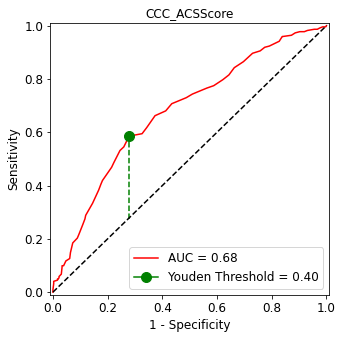

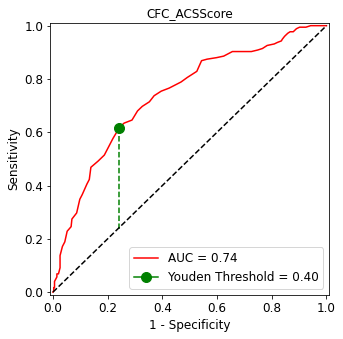

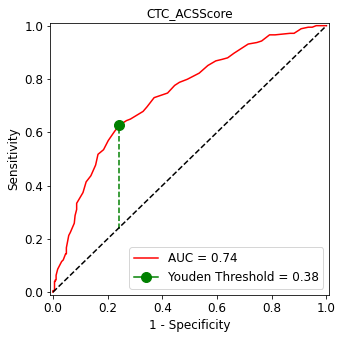

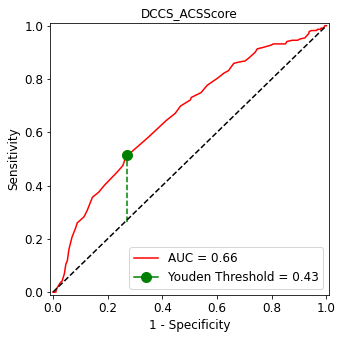

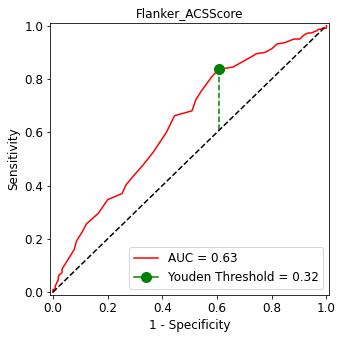

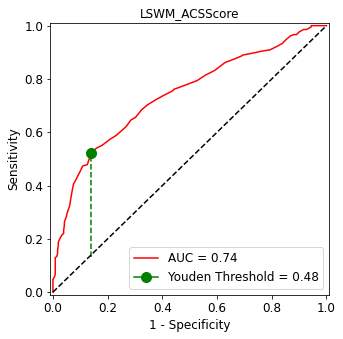

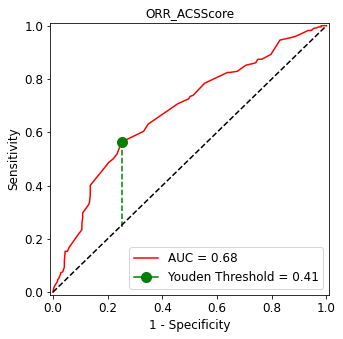

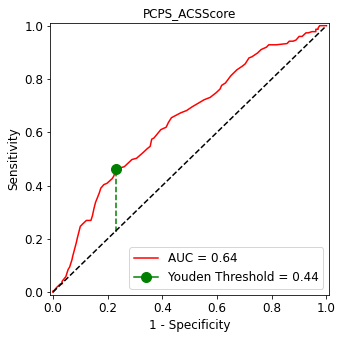

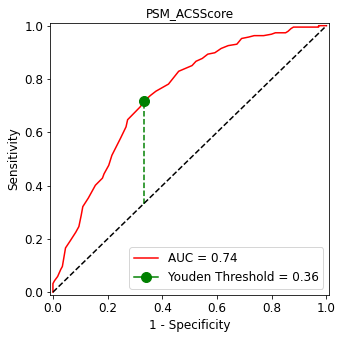

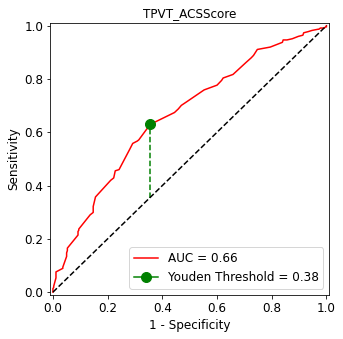

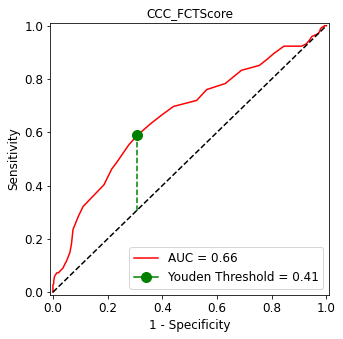

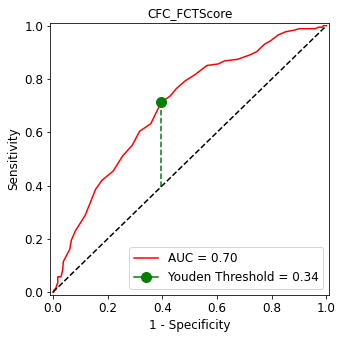

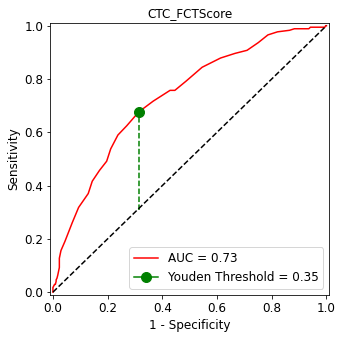

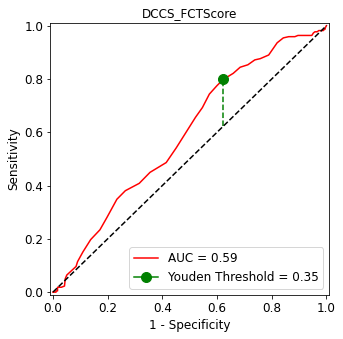

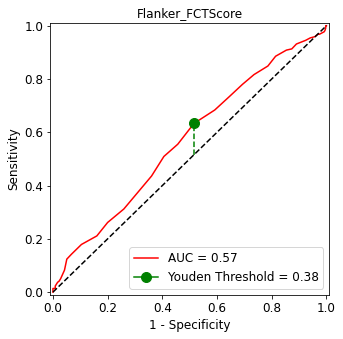

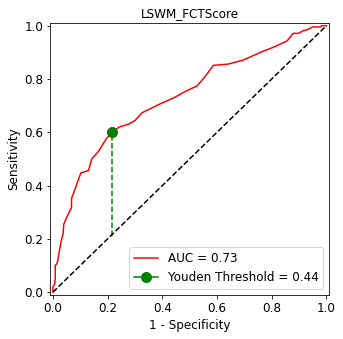

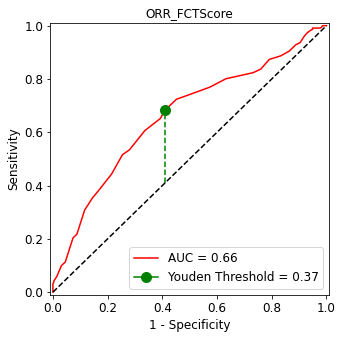

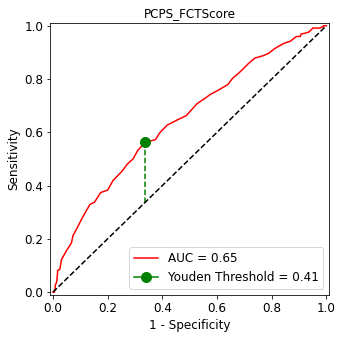

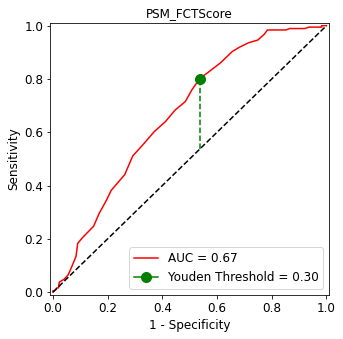

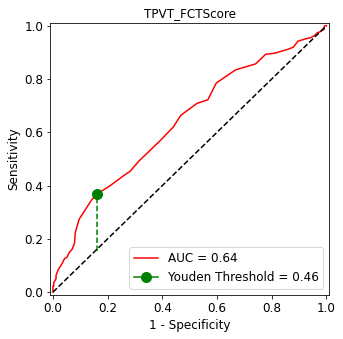

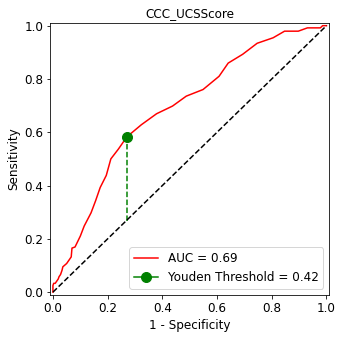

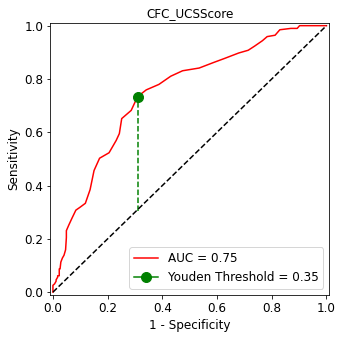

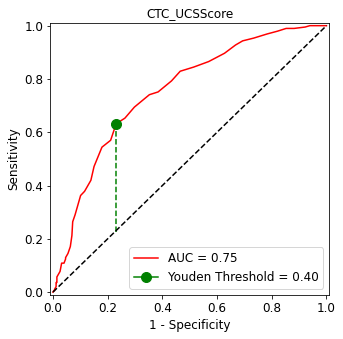

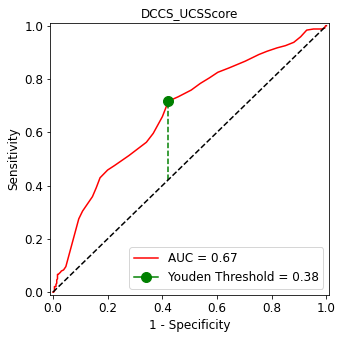

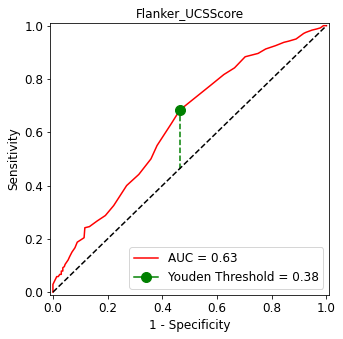

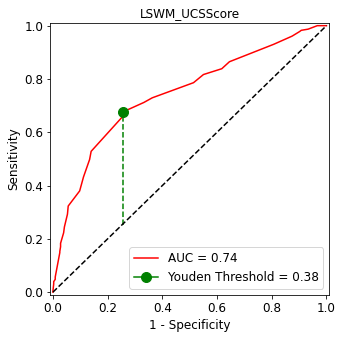

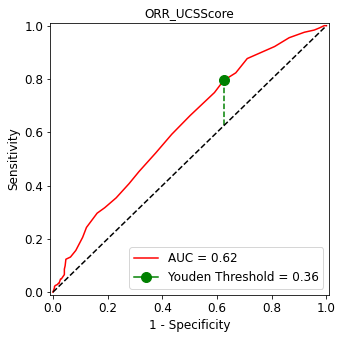

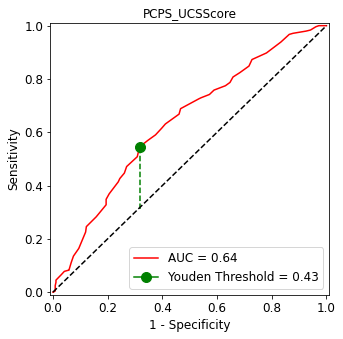

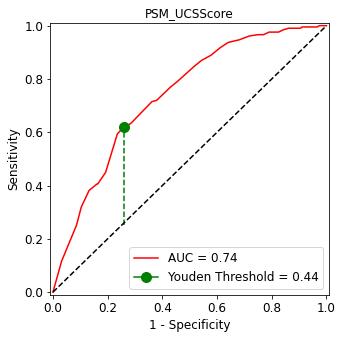

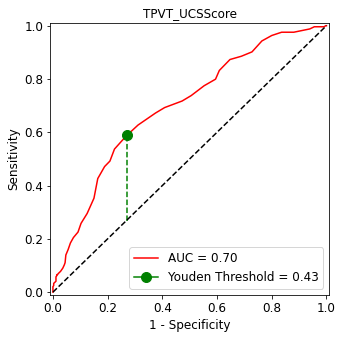

In [65]:
fa =[]
for variables in dv:
    
    rv = []
    for col in variables: 
        if 'UCS' in col:
            X, y, t = select_subset(dfi, col, True)
        else:
            X, y, t = select_subset(dfi, col)
        df1 = _threshold_finder(X, y , col)
        rv.append(df1)
    temp = pd.concat(rv)
    fa.append(temp)

set1 = pd.concat(fa, ignore_index=True)



In [67]:
set1

,Title,Accuracy,AUC-ROC,95% CI,Min_Sample,AVG Precision,Youden index,"Precision,Recall,F1 at_50"
0,CCC_ACSScore,0.66,0.68,"(0.63, 0.72)",35.26,0.55,0.40,"(0.52, 0.68, 0.59)"
1,CFC_ACSScore,0.72,0.74,"(0.69, 0.79)",29.78,0.57,0.40,"(0.51, 0.75, 0.61)"
2,CTC_ACSScore,0.72,0.74,"(0.69, 0.79)",29.81,0.56,0.38,"(0.5, 0.75, 0.6)"
3,DCCS_ACSScore,0.66,0.66,"(0.62, 0.71)",36.72,0.51,0.43,"(0.49, 0.64, 0.56)"
4,Flanker_ACSScore,0.64,0.63,"(0.59, 0.68)",40.01,0.49,0.32,"(0.48, 0.64, 0.55)"
5,LSWM_ACSScore,0.74,0.74,"(0.7, 0.78)",29.73,0.66,0.48,"(0.53, 0.72, 0.61)"
6,ORR_ACSScore,0.66,0.68,"(0.63, 0.72)",35.06,0.55,0.41,"(0.54, 0.71, 0.61)"
7,PCPS_ACSScore,0.64,0.64,"(0.6, 0.69)",38.97,0.50,0.44,"(0.49, 0.64, 0.55)"
8,PSM_ACSScore,0.68,0.74,"(0.69, 0.79)",29.64,0.57,0.36,"(0.53, 0.75, 0.62)"
9,TPVT_ACSScore,0.64,0.66,"(0.62, 0.71)",36.62,0.54,0.38,"(0.52, 0.67, 0.59)"


# just these sites: UWisc, MGH, NU, and UMich

In [45]:
df.site.value_counts()

CU       197
UMich    117
UWisc    114
Mass     106
UCSD      81
NU        75
Emory     66
UPitt     38
Mayo      23
Name: site, dtype: int64

In [46]:
#just these sites: UWisc, MGH, NU, and UMich
dfs = df[(df['site'] == 'UMich') | (df['site'] == 'UWisc')|(df['site'] == 'Mass')|(df['site'] == 'NU')   ]

In [47]:
dfs.shape

(412, 77)

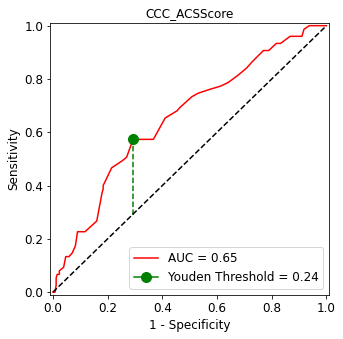

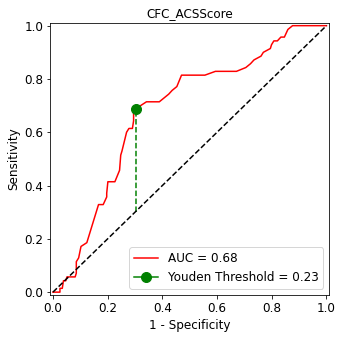

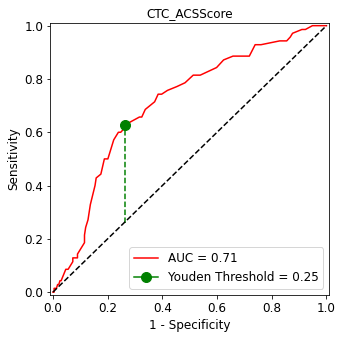

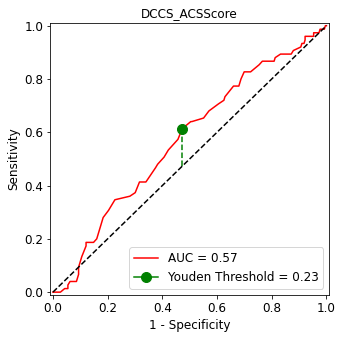

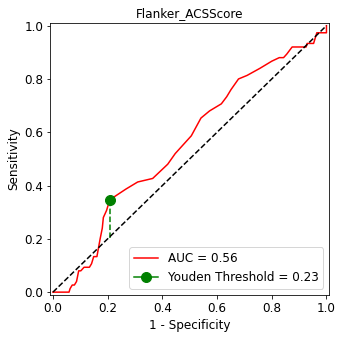

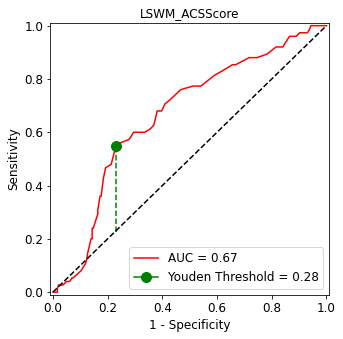

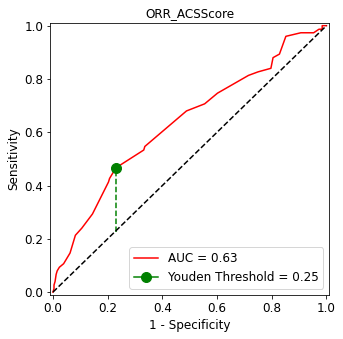

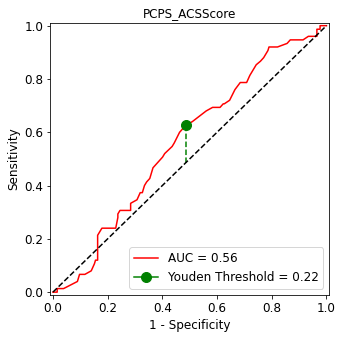

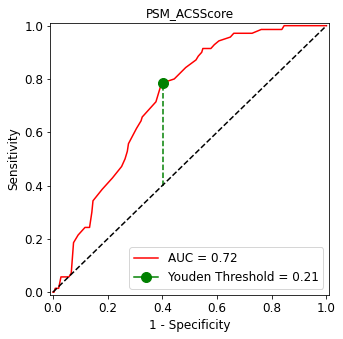

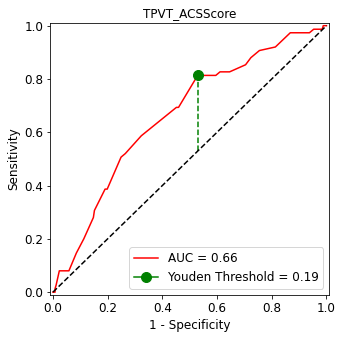

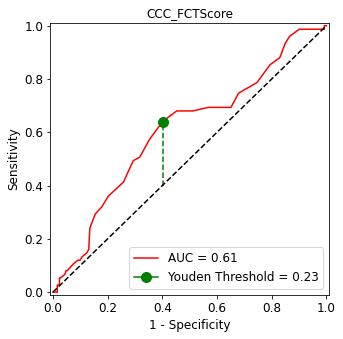

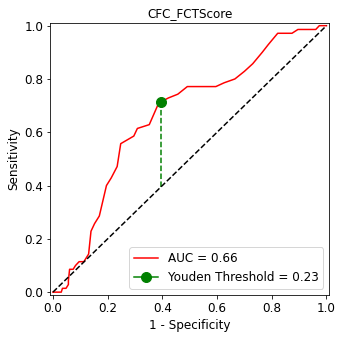

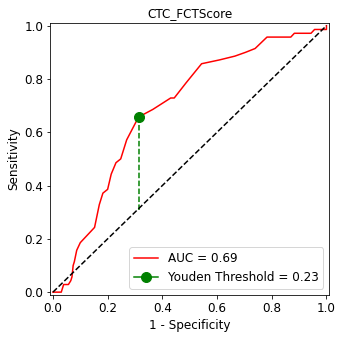

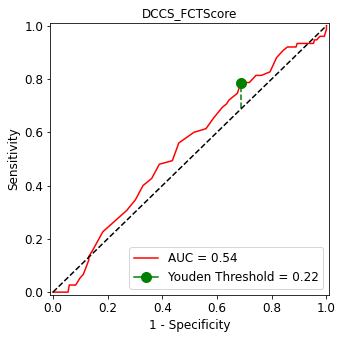

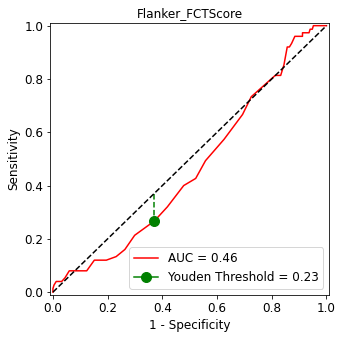

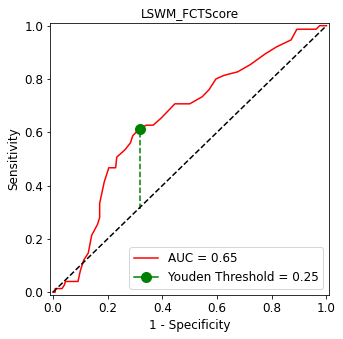

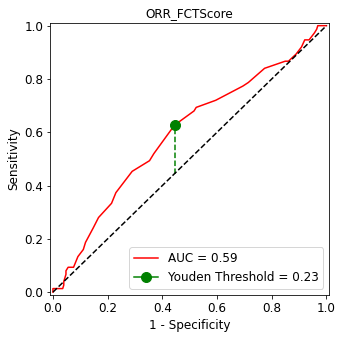

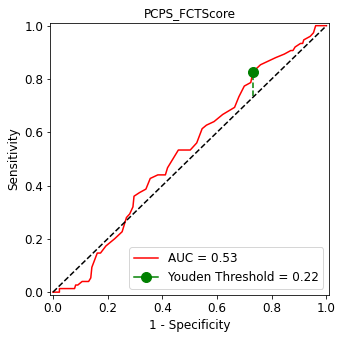

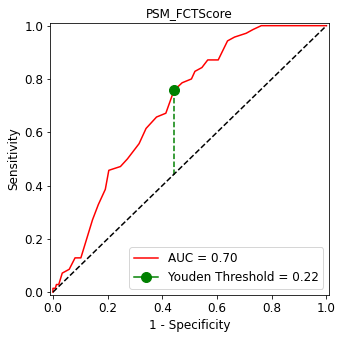

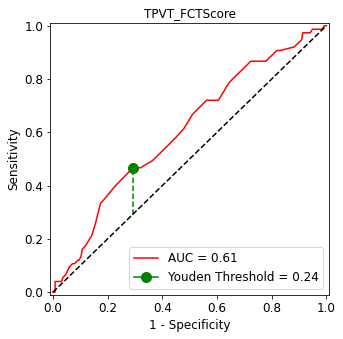

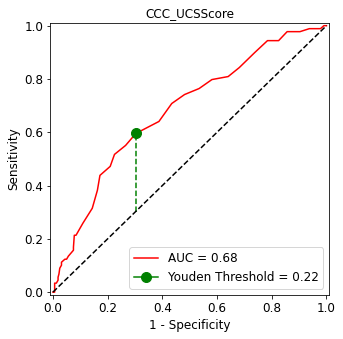

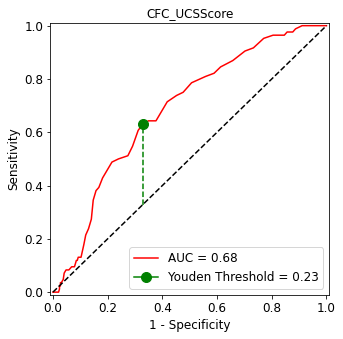

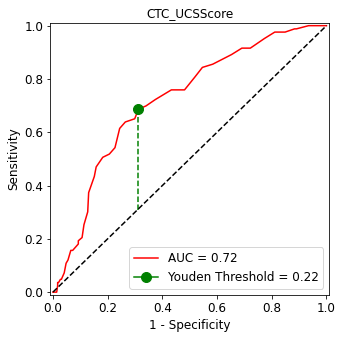

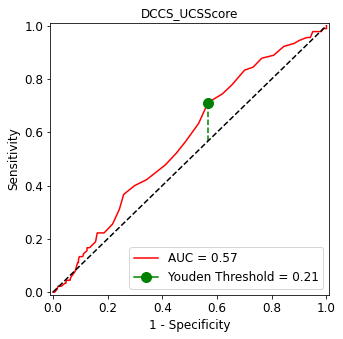

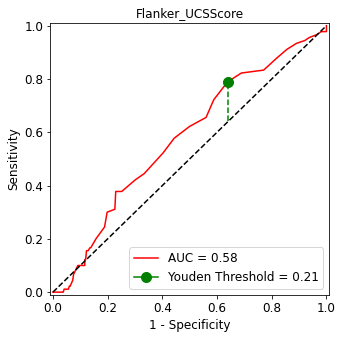

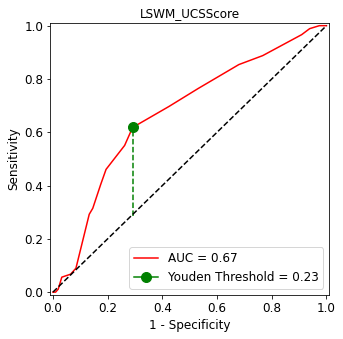

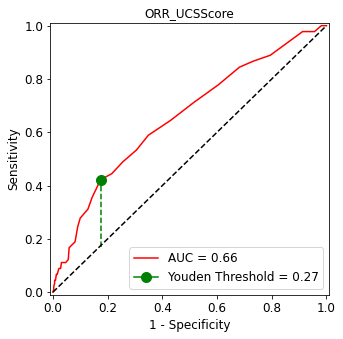

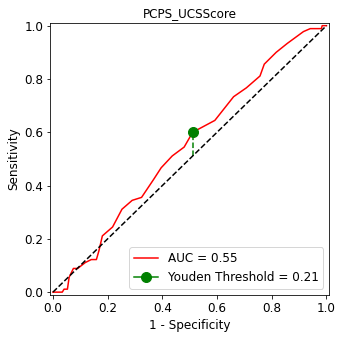

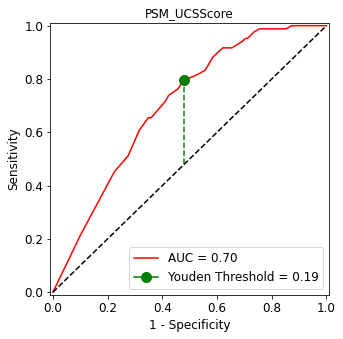

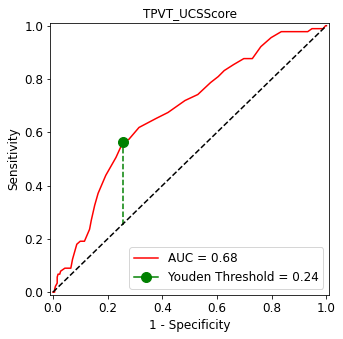

In [66]:
fa =[]
for variables in dv:
    
    rv = []
    for col in variables: 
        if 'UCS' in col:
            X, y, t = select_subset(dfs, col, True)
        else:
            X, y, t = select_subset(dfs, col)
        df1 = _threshold_finder(X, y , col)
        rv.append(df1)
    temp = pd.concat(rv)
    fa.append(temp)

set2 = pd.concat(fa, ignore_index=True)

In [68]:
with pd.ExcelWriter('output.xlsx') as writer:  
    set1.to_excel(writer, sheet_name='All',index= False)
    set2.to_excel(writer, sheet_name='Selectd_sites',index=False)